In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from matplotlib.ticker import FuncFormatter

# Load Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('../Data/stores.csv')
df_items = pd.read_csv('../Data/items.csv')
df_transactions = pd.read_csv('../Data/transactions.csv')
df_oil = pd.read_csv('../Data/oil.csv')
# Processed holidays_events
df_holidays_events = pd.read_csv('../Data/holidays_events_featured.csv')

# filtered and preprocessed train
df_train = pd.read_csv('../Data/train_Guayas_preprocessed.csv')

In [4]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14,2605,0,0
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.97,2462,0,0
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.12,2607,0,0
3,24,105574,2013-01-05,140805.0,4.0,0,0,NaN,2578,0,0
4,24,105574,2013-01-06,182800.0,7.0,0,0,NaN,2061,0,0


# Filter dataset upto 31-03-2014

In [5]:
print(df_train['date'].min())
print(df_train['date'].max())
print(df_train.shape)

2013-01-02
2017-08-15
(35069356, 11)


In [6]:
max_date='2014-04-01'
df_train=df_train[df_train['date'] < max_date]
print(df_train.shape)

(9437752, 11)


## Save the filtered dataset

In [7]:
#Save the CSV to the drive
#df_train.to_csv('Data/train_Guayas_processed_filtered.csv', index=False)
#Read data automatically from drive
#df_train = pd.read_csv('Data/train_Guayas_processed_filtered.csv')

# Feature Engineering

In [8]:
# Ensure datetime, sorting
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])

## Time-based Features (Calendar Context)

These help the model learn weekly/monthly/seasonal patterns

In [9]:
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week
df_train['year'] = df_train['date'].dt.year
df_train['is_month_start'] = df_train['date'].dt.is_month_start.astype(int)
df_train['is_month_end'] = df_train['date'].dt.is_month_end.astype(int)


## Lag features

In [10]:
# sales from the previous day, previous week are used to Create lag features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_30'] = df_train['unit_sales'].shift(30)


# Drop rows where ANY of these columns are null
df_train= df_train.dropna(subset=['lag_1', 'lag_7', 'lag_30'], how='any').reset_index(drop=True)

In [11]:
# Convert 'date' to datetime and group daily sales
df_train['date'] = pd.to_datetime(df_train['date'])

# Aggregate total daily sales
#Combines stores or items to get total sales per day, ensures one row per day (even if there was no sale
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Reindex to daily frequency and fill missing dates
#Makes sure that the data is set to daily frequency, meaning there’s one row for every single day — even if there were no sales on some days
#If there are any missing days (with no sales recorded), this fills them using the last available value (forward fill)
daily_sales = daily_sales.asfreq('D').ffill()

### AFC

The Autocorrelation Function (ACF) plot shows how a time series is correlated with its previous values (lags). It captures both the direct relationship and the indirect influence of intermediate past points on the current data.

<Figure size 1000x500 with 0 Axes>

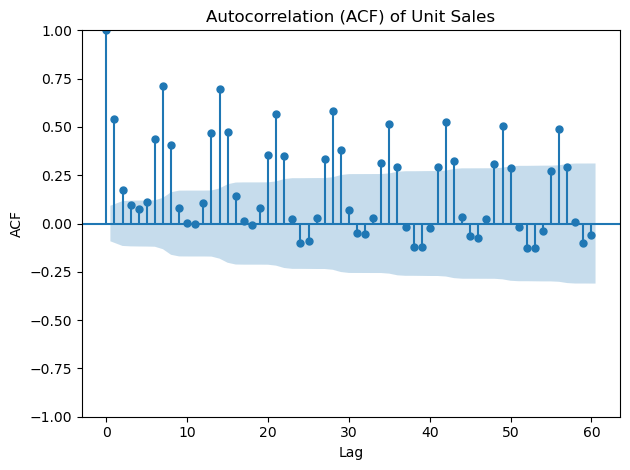

In [12]:
#Using lags=60 lets us see how today's sales are related to sales from the past 60 days. This helps us find repeating patterns or trends in the data over time.

plt.figure(figsize=(10, 5))  # Set the size of the plot
plot_acf(daily_sales.dropna(), lags=60)  # Plot autocorrelation for lags up to 60 days
plt.title('Autocorrelation (ACF) of Unit Sales')  # Add a title to the plot
plt.xlabel('Lag')       # Label the x-axis as 'Lag' (how many days back)
plt.ylabel('ACF')  # Label the y-axis to show the strength of correlation
plt.tight_layout()      # Adjust layout to prevent clipping of labels
plt.show()              # Display the plot

Observations from ACF Plot:

- Strong connection with yesterday (Lag 1): Today’s sales are very similar to yesterday’s, showing a clear daily pattern.

- Weekly patterns (Lags 7, 14, 21...): Spikes at these lags suggest people often shop on the same days each week.

- Long-term trend (up to Lag 60): Many bars are outside the blue area, meaning these patterns are real (not random), and the sales trend changes over time (non-stationary data).



### PAFC

The PACF plot shows the direct relationship between a time series and its past values (lags), after removing the influence of intermediate lags. It helps identify how much each lag individually contributes to the current value

<Figure size 1000x500 with 0 Axes>

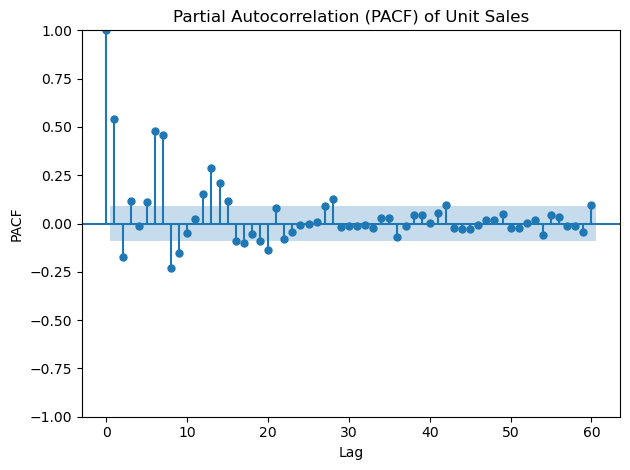

In [13]:
## This plot shows the Partial Autocorrelation Function (PACF) for daily unit sales.
plt.figure(figsize=(10, 5))
plot_pacf(daily_sales.dropna(), lags=60, method='ywm')
plt.title('Partial Autocorrelation (PACF) of Unit Sales')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()

Observation:
- The PACF plot shows a strong spike at lag 1, indicating that most of the time series memory is captured by the immediately preceding day — suggesting a strong AR(1) component.

- Additional significant spikes are visible up to lag 7, which may imply short-term dependencies or weekly seasonality.
- Beyond lag 10, most values fall within the confidence interval, suggesting limited direct influence from longer lags.









In [14]:
## First, sort the data by store, item, and date to ensure the lags are accurate.
df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])

# Create lag features for past sales (e.g., 1, 7, 14, 21, 30, 60 days ago)
# This gives the model "memory" — it can learn patterns from the past
for lag in [1, 7,14, 21, 30, 60]:
    df_train[f'lag_{lag}'] = df_train.groupby (['store_nbr', 'item_nbr']) ['unit_sales'].shift(lag)
    # For each store-item combination, shift the 'unit_sales' column by 'lag' days

## Rolling Window

Rolling Window calculates the average or variation (standard deviation) of sales over a fixed number of past days (like 7, 14, or 30 days) for each date. It looks backward from the current day (excluding it to avoid data leakage). This smooths out short-term fluctuations, captures recent trends, and shows how much sales vary over time. These features give the model important information about recent sales patterns, helping improve forecasting accuracy.

In [15]:
# Weekly seasonality (common in retail), sales pattern repeats every week, shift 1 to prevent data leakage
# Define rolling windows
windows = [7, 14, 30]

# Generate rolling features
for w in windows:
    df_train[f'rolling_mean_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).mean())

    df_train[f'rolling_std_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).std())

## Exponential Moving Average (EWM) Features

EWM features smooth out short-term fluctuations in sales data while giving more weight to recent observations. This helps the model detect recent trends and changing patterns more responsively than simple rolling averages. By capturing the evolving trend and volatility over different time spans (e.g., 7, 14, 30 days), EWM features improve the model’s ability to forecast future sales accurately, especially when recent changes matter more than older data.

In [16]:
spans = [7, 14, 30]
for span in [7, 14, 30]:
    #shift(1) For each store and item combination, it looks at the past unit_sales.
    #calculates the EWM mean over the given span, The EWM mean gives a smoothed average where recent days have more influence.
    df_train[f'ewm_mean_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
    #calculates EWM standard deviation over the given span, shows how much sales varied (spread out) over that period.
    df_train[f'ewm_std_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).std())


## Holiday Effects

This feature shifts the holiday and event flags so each row indicates if tomorrow is a holiday or event by shifting the holiday/event flag backward by one day.

It helps the model learn whether to expect a sales increase due to upcoming holidays or events, improving prediction by capturing changes in customer behavior ahead of those days.

In [17]:
# Shift 'is_holiday' column up by 1 row to get info about tomorrow's holiday status today
df_train['next_is_holiday'] = df_train['is_holiday'].shift(-1)

# Replace any missing values (at the end) with 0 (no holiday)
df_train['next_is_holiday'] = df_train['next_is_holiday'].fillna(0).astype(int)

# Do the same for the 'is_event' column to get tomorrow's event status
df_train['next_is_event'] = df_train['is_event'].shift(-1).fillna(0).astype(int)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437722 entries, 0 to 9437721
Data columns (total 39 columns):
 #   Column           Dtype         
---  ------           -----         
 0   store_nbr        int64         
 1   item_nbr         int64         
 2   date             datetime64[ns]
 3   id               float64       
 4   unit_sales       float64       
 5   onpromotion      int64         
 6   outlier          int64         
 7   dcoilwtico       float64       
 8   transactions     int64         
 9   is_holiday       int64         
 10  is_event         int64         
 11  dayofweek        int32         
 12  is_weekend       int64         
 13  month            int32         
 14  day              int32         
 15  weekofyear       UInt32        
 16  year             int32         
 17  is_month_start   int64         
 18  is_month_end     int64         
 19  lag_1            float64       
 20  lag_7            float64       
 21  lag_30           float64       

In [19]:
# correct the datatype for store_nbr and item_nbr
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train[ 'item_nbr'].astype('category')

In [20]:
#Because it’s store-level only and not item-level?
#df_train = df_train.drop(columns=['transactions'])

## Outlier Memory features
These features help the model remember if unusual sales behavior (outliers) happened recently for each store-item pair. Outliers often indicate sudden spikes or drops in sales that can affect future sales patterns.

We create lagged outlier features to check if outliers occurred in the past (1, 7, 14, 30 days). This helps the model learn from recent unusual sales for better forecasting.

Using groupby(['store_nbr', 'item_nbr']) ensures we calculate these lags separately for each store and item combination, so the model gets specific context for each product in each store.

The rolling mean of outliers over the past 7 days captures how often outliers occurred recently, providing a sense of instability or unusual activity in recent sales.


In [21]:

# Make sure data is sorted by store, item, and date for correct shifting
# Create new columns to remember if an outlier happened 1, 7, 14, or 30 days ago
for days_ago in [1, 7, 14, 30]:
    df_train[f'outlier_lag_{days_ago}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(days_ago)

# Calculate how often outliers happened in the past 7 days (excluding today)
df_train['outlier_rolling_mean_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].transform(
    lambda x: x.shift(1).rolling(7).mean()
)

# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())
df_train['unit_sales_30d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=30).mean())

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_50053/1493184018.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{days_ago}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(days_ago)
/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_50053/1493184018.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{days_ago}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(days_ago)
/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_50053/1493184018.py:4: FutureWarning: The default of observed=False is deprecated a

## Promotion Features

This feature shows if a product was on promotion one week ago for each store and item. It helps the model learn how promotions affect sales over time, not just on the promotion day but also in the days after. This way, the model can better predict sales by understanding the lasting impact of promotions.

In [22]:
#It groups the data by each store and item pair, for each group, it takes the onpromotion column (which shows if the product was on promotion that day).
#It shifts this column down by 7 rows (days), so the value from 7 days ago moves to the current row

df_train['promo_last_week'] = df_train.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_50053/598144905.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['promo_last_week'] = df_train.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)


In [23]:
df_train.shape

(9437722, 47)

In [24]:
df_train.corr(numeric_only=True)

,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event,dayofweek,is_weekend,...,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7,unit_sales_7d_avg,unit_sales_30d_avg,promo_last_week
id,1.000000,0.013529,NaN,0.011803,0.291972,0.000663,-0.043840,NaN,0.000745,0.007572,...,-0.044703,NaN,0.010517,0.010122,0.009268,0.008501,0.026498,0.011083,0.001969,NaN
unit_sales,0.013529,1.000000,NaN,0.017735,0.011052,0.139624,-0.002775,NaN,0.029804,0.040965,...,-0.003083,NaN,0.015700,0.014950,0.015093,0.013812,0.039786,0.824886,0.779039,NaN
onpromotion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outlier,0.011803,0.017735,NaN,1.000000,0.001258,0.009295,-0.000799,NaN,0.001577,0.001605,...,-0.000799,NaN,0.002672,0.001355,0.002326,0.001994,0.005127,0.019167,0.018374,NaN
dcoilwtico,0.291972,0.011052,NaN,0.001258,1.000000,0.022307,0.112701,NaN,0.002823,NaN,...,0.125470,NaN,0.001368,0.001333,0.001818,0.001392,0.003265,0.015148,0.014926,NaN
transactions,0.000663,0.139624,NaN,0.009295,0.022307,1.000000,-0.011056,NaN,0.076901,0.100104,...,-0.006166,NaN,0.008535,0.008964,0.008813,0.008461,0.022156,0.150083,0.152860,NaN
is_holiday,-0.043840,-0.002775,NaN,-0.000799,0.112701,-0.011056,1.000000,NaN,0.027007,0.008478,...,0.328899,NaN,-0.000797,-0.000130,-0.001167,-0.000594,-0.000641,-0.002839,-0.001851,NaN
is_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dayofweek,0.000745,0.029804,NaN,0.001577,0.002823,0.076901,0.027007,NaN,1.000000,0.790395,...,-0.013773,NaN,0.000224,0.001469,0.001403,-0.000633,0.000012,0.000068,0.000842,NaN
is_weekend,0.007572,0.040965,NaN,0.001605,NaN,0.100104,0.008478,NaN,0.790395,1.000000,...,0.008478,NaN,0.000670,0.001453,0.001375,-0.000209,0.000143,0.000243,0.002286,NaN


# Save Preprocessed & Feature-Engineered Training Data
In this step, we save the cleaned and feature-enhanced training dataset for future use or model training.

In [25]:
#df_train.to_csv('train_Guayas_final.csv', index= False)
#from google.colab import files
#files.download('train_Guayas_final.csv')

In [26]:
#Save the CSV to the drive
df_train.to_csv('../Data/train_Guayas_final.csv', index=False)
#Read data automatically from drive
#df_train_final = pd.read_csv('../Data/train_Guayas_final.csv')


In [27]:
df_train.shape

(9437722, 47)

In [28]:
df_train.columns

Index(['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion',
       'outlier', 'dcoilwtico', 'transactions', 'is_holiday', 'is_event',
       'dayofweek', 'is_weekend', 'month', 'day', 'weekofyear', 'year',
       'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_30', 'lag_14',
       'lag_21', 'lag_60', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14',
       'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'next_is_holiday',
       'next_is_event', 'outlier_lag_1', 'outlier_lag_7', 'outlier_lag_14',
       'outlier_lag_30', 'outlier_rolling_mean_7', 'unit_sales_7d_avg',
       'unit_sales_30d_avg', 'promo_last_week'],
      dtype='object')

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437722 entries, 0 to 9437721
Data columns (total 47 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_nbr               category      
 1   item_nbr                category      
 2   date                    datetime64[ns]
 3   id                      float64       
 4   unit_sales              float64       
 5   onpromotion             int64         
 6   outlier                 int64         
 7   dcoilwtico              float64       
 8   transactions            int64         
 9   is_holiday              int64         
 10  is_event                int64         
 11  dayofweek               int32         
 12  is_weekend              int64         
 13  month                   int32         
 14  day                     int32         
 15  weekofyear              UInt32        
 16  year                    int32         
 17  is_month_start          int64         
 18  is

In [30]:
df_train.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
id                        6690457
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                2702432
transactions                    0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_30                     623640
lag_14                     291032
lag_21                     436548
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_3